In [1]:
import os
import sys
import numpy as np
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing.label import LabelEncoder

from torch import Tensor, LongTensor
from torch.utils.data import DataLoader, Sampler
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

from IPython.display import clear_output
%pylab inline

from slayer_mod import SLayer
#from provider import _data_setup
from train_functions import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Our data is in the form [dim0cls0, dim0cls1, dim1cls0, dim1cls1] where dim0cls0 is a list of arrays

datapath = '/home/robert/forex/data/tda/persistences_5-3-3-2.pkl'
input = open(datapath, 'rb')
data = pickle.load(file=input)

In [3]:
'''
# We combine 0th and 1st dimensional homologies
cls0 = []
cls1 = []
for i in range(len(data[0])):
    cls0.append(np.concatenate((data[0][i], data[2][i]), axis=0))
for i in range(len(data[1])):
    cls1.append(np.concatenate((data[1][i], data[3][i]), axis=0))
'''
# Need just one list of arrays along with list of classes
# Right now, we are only working with 1D homologies
classes = []
# for i in range(len(data[0])):
#     classes.append(0)
# for i in range(len(data[1])):
#     classes.append(1)
for i in range(len(data[2])):
    classes.append(0)
for i in range(len(data[3])):
    classes.append(1)

# alldata = data[0] + data[1] + data[2] + data[3]
alldata = data[2] + data[3]
alldata = [torch.from_numpy(x) for x in alldata]
classes = [torch.from_numpy(numpy.array(x)) for x in classes]

In [4]:
len(alldata)

3591

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(alldata, classes, test_size=0.33, random_state=42)

In [6]:
y_train = torch.Tensor(y_train).long()
y_test = torch.Tensor(y_test).long()

In [7]:
train_data = [(X_train[i:i+7], y_train[i:i+7]) for i in range(0, len(y_train), 7)] # Batch size of 7
test_data = [(X_test[i:i+7], y_test[i:i+7]) for i in range(0, len(y_test), 7)] # Batch size of 7

In [8]:
cuda_n = 0

params = {
        'data_path': None,
        'epochs': 300,
        'momentum': 0.7,
        'lr_start': 0.05,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'test_ratio': 0.1,
        'batch_size': 7,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

In [9]:
class FXnet(torch.nn.Module):
    def __init__(self, n_elements, n_classes):
        super().__init__()
        
        self.slayer = SLayer(n_elements=n_elements, point_dimension=2) # Outputs batch_size x n_elements tensor
        
        self.stage1 = torch.nn.Sequential(
            nn.Linear(n_elements, 10),
            nn.BatchNorm1d(num_features=10),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Dropout(0,4))
        
        self.fc = nn.Linear(5, n_classes)
        
    def forward(self, input):
        x = self.slayer(input)
        x = self.stage1(x)
        x = self.fc(x)
        return x

In [10]:
def train_one_epoch(model, optimizer, train_data, params, criterion, variable_created_by_model):
    
    # training
    train_loss = []
    train_preds = []
    train_targets = []
    model.train(True)
    for item in train_data: # size of batch is one multiset?
        batch_input, batch_target = item
        # transform input to tensor
        # batch_input, batch_target = data_typing(batch_input, batch_target, params)
        
        # if not variable_created_by_model:
        #     batch_input = Variable(batch_input)
        # batch_target = Variable(batch_target)
        # print(batch_input, batch_target)
        
        start_time = time.time()
        optimizer.zero_grad()
        batch_output = model(batch_input)
        # print("forward pass - {:3f}s".format(time.time() - start_time))
        loss = criterion(batch_output, batch_target)
        # print('loss: ', loss.item())
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_preds.extend(list(compute_labels(batch_output)))
        train_targets.extend(list(batch_target.cpu().data.numpy()))
    
    return train_loss, train_preds, train_targets

In [11]:
'''
I think the problem is the format of the training data. Right now it is of the following form:
    [tuple, tuple, tuple, ...]
    where each tuple contains 
        1) a list of tensors (each tensor is a set of points corresponding to
        a filtration) of length batch_size
        2) a tensor of length batch_size containing class labels (0 or 1)
I've tried a lot of different forms. For some reason, it works for the first pass, but not for any
    subsequent passes.
'''

model = FXnet(10, 2)
optimizer = optim.SGD(model.parameters(),
                      lr=params['lr_start'],
                      momentum=params['momentum'])
criterion=nn.CrossEntropyLoss()

# one, two, three = train_one_epoch(model, optimizer, train_data, 
#                                   criterion, params, 
#                                   variable_created_by_model=True)

In [12]:
def train(model, optimizer, train_data, val_data, params, metric=accuracy_score, criterion=nn.CrossEntropyLoss(), variable_created_by_model=True):
    
    mean_train_loss = []
    mean_val_loss = []
    mean_train_metric = []
    mean_val_metric = []

    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    
    for epoch in range(params["epochs"]):
        epoch_start_time = time.time()
        
        scheduler.step()
        print("current lr = {}".format(scheduler.get_lr()[0]))
        
        start_time = time.time()
        train_loss, train_preds, train_targets = train_one_epoch(
            model, optimizer, train_data, params, criterion, variable_created_by_model)
        print("train epoch - {:.3f}s".format(time.time() - start_time))
        start_time = time.time()
        val_loss, val_preds, val_targets = validate(
            model, val_data, params, criterion, variable_created_by_model)
        print("validate - {:3f}s".format(time.time() - start_time))

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
        mean_train_metric.append(metric(train_targets, train_preds))
        mean_val_metric.append(metric(val_targets, val_preds))
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, params["epochs"], time.time() - epoch_start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
        
#         if mean_train_loss[-1] < epsilon:
#             break

    return mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric

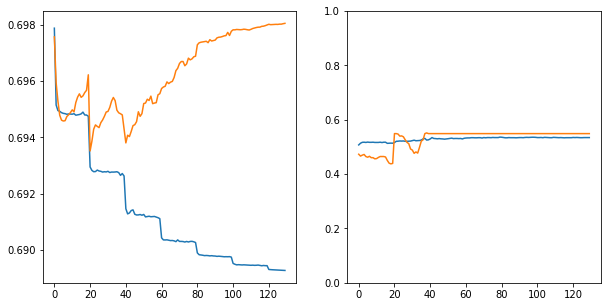

Epoch 130 of 300 took 6.416s
  training loss (in-iteration): 	0.689269
  validation loss: 			0.698051
  training metric: 			0.53
  validation metric: 			0.55
current lr = 0.00078125


KeyboardInterrupt: 

In [13]:
mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(model, optimizer, train_data, 
                                                                           test_data, params, accuracy_score)